In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def generate_splits(total_days=1699, val_size=21, n_splits=10, purge_size=7):
    """Generate random splits where purge windows can overlap with each other but not validation periods"""
    splits = []
    val_and_purge_days = set()  # Track all days that can't be used for new validation periods
    validation_only_days = set()  # Track just validation days to return clean splits
    
    while len(splits) < n_splits:
        start = np.random.randint(0, total_days - val_size)
        end = start + val_size - 1  # -1 because end is inclusive
        
        # Calculate purge windows
        purge_start = max(0, start - purge_size)
        purge_end = min(total_days - 1, end + purge_size)
        
        # Check if validation period would overlap with any validation period or purge window
        validation_range = range(start, end + 1)
        if not any(day in val_and_purge_days for day in validation_range):
            splits.append((start, end))
            # Add validation days to both sets
            validation_only_days.update(validation_range)
            val_and_purge_days.update(validation_range)
            # Add purge days only to the set that blocks new validation periods
            val_and_purge_days.update(range(purge_start, start))
            val_and_purge_days.update(range(end + 1, purge_end + 1))
    
    return sorted(splits)

In [36]:
def plot_multiple_splits(n_models=5, total_days=1699, val_size=21, n_splits=10, purge_size=7):
    """Plot multiple sets of train/validation splits with purge windows"""
    plt.figure(figsize=(15, 6))
    
    # Generate and plot splits for each model
    all_splits = []
    for model in range(n_models):
        splits = generate_splits(total_days, val_size, n_splits, purge_size)
        all_splits.append(splits)
        
        # Plot full timeline
        y_pos = model * 0.3
        plt.hlines(y=y_pos, xmin=0, xmax=total_days, color='blue', alpha=0.3, linewidth=20, 
                  label='Train' if model==0 else "")
        
        # Plot validation sections and purge windows
        for i, (start, end) in enumerate(splits, 1):
            # Plot purge windows
            purge_start = max(0, start - purge_size)
            purge_end = min(total_days - 1, end + purge_size)
            plt.hlines(y=y_pos, xmin=purge_start, xmax=start, color='yellow', alpha=0.3, linewidth=20,
                      label='Purge' if model==0 and i==1 else "")
            plt.hlines(y=y_pos, xmin=end, xmax=purge_end, color='yellow', alpha=0.3, linewidth=20)
            
            # Plot validation section
            plt.hlines(y=y_pos, xmin=start, xmax=end, color='red', alpha=0.5, linewidth=20, 
                      label='Validation' if model==0 and i==1 else "")
            plt.text(start + (end-start)/2, y_pos+0.05, f'{i}', ha='center')
    
    plt.ylim(-0.2, (n_models-1)*0.3 + 0.2)
    plt.xlabel('Days')
    plt.ylabel('Model')
    plt.title(f'Multiple Train/Validation Split Visualizations\n(Val Size: {val_size}, Purge: {purge_size} days)')
    plt.legend()
    
    plt.yticks([i*0.3 for i in range(n_models)], [f'Model {i+1}' for i in range(n_models)])
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display comprehensive overlap statistics
    print("\nValidation Coverage and Overlap Analysis:")
    print(f"\nConfiguration:")
    print(f"- Total dataset: {total_days} days")
    print(f"- Validation size: {val_size} days x {n_splits} splits = {val_size * n_splits} days per model")
    print(f"- Purge window: {purge_size} days each side")
    
    # Calculate unique validation days and purge days across all models
    all_val_days = set()
    all_purge_days = set()
    for splits in all_splits:
        model_val_days = set()
        model_purge_days = set()
        for start, end in splits:
            model_val_days.update(range(start, end + 1))
            purge_start = max(0, start - purge_size)
            purge_end = min(total_days - 1, end + purge_size)
            model_purge_days.update(range(purge_start, start))
            model_purge_days.update(range(end + 1, purge_end + 1))
        all_val_days.update(model_val_days)
        all_purge_days.update(model_purge_days)
    
    print(f"\nCoverage:")
    print(f"- Unique validation days: {len(all_val_days)} ({len(all_val_days)/total_days*100:.1f}% of total)")
    print(f"- Unique purge days: {len(all_purge_days)} ({len(all_purge_days)/total_days*100:.1f}% of total)")
    print(f"- Total unique days used: {len(all_val_days | all_purge_days)} ({len(all_val_days | all_purge_days)/total_days*100:.1f}% of total)")
    
    print("\nPairwise Model Overlaps (validation days only):")
    for i in range(n_models):
        for j in range(i+1, n_models):
            model1_days = set()
            for start, end in all_splits[i]:
                model1_days.update(range(start, end + 1))
            
            model2_days = set()
            overlap_count = 0
            for start, end in all_splits[j]:
                days = set(range(start, end + 1))
                model2_days.update(days)
                overlap_count += len(days.intersection(model1_days))
            
            print(f"Models {i+1} and {j+1}:")
            print(f"  - Overlap: {overlap_count} days")
            print(f"  - {overlap_count/(val_size*n_splits)*100:.1f}% of each model's validation data")
            print(f"  - {overlap_count/total_days*100:.1f}% of total dataset")


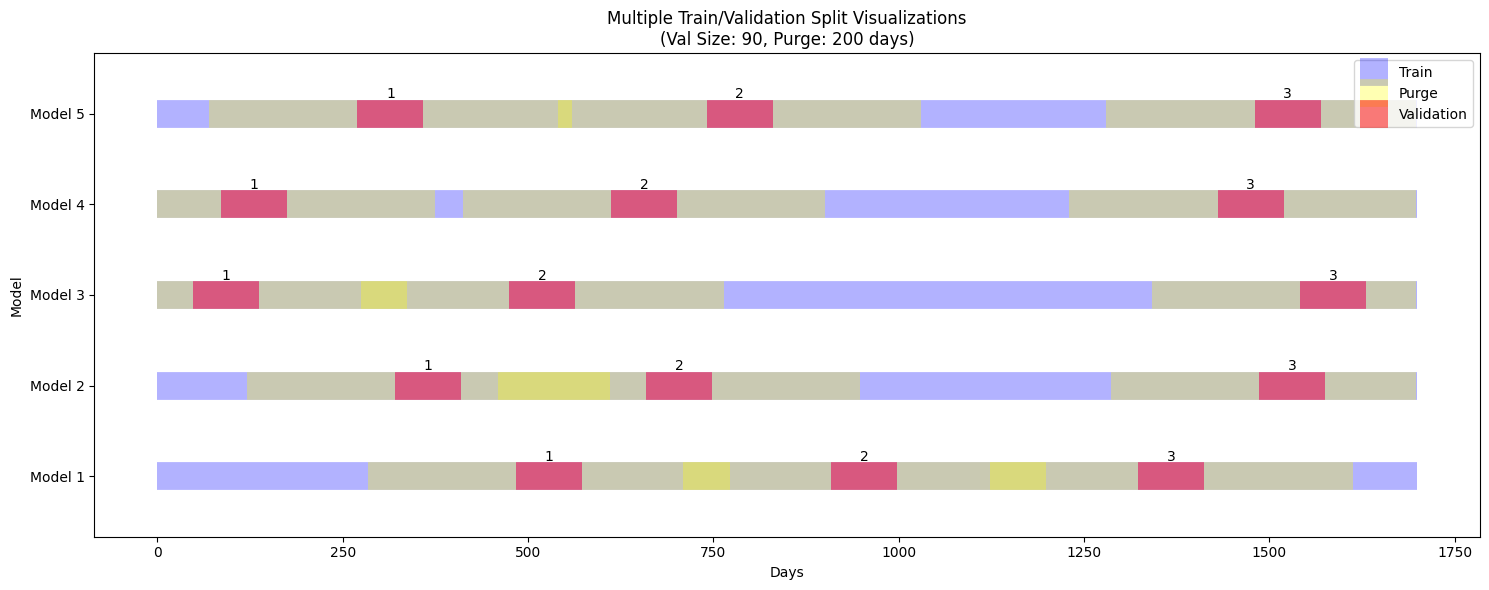


Validation Coverage and Overlap Analysis:

Configuration:
- Total dataset: 1699 days
- Validation size: 90 days x 3 splits = 270 days per model
- Purge window: 200 days each side

Coverage:
- Unique validation days: 968 (57.0% of total)
- Unique purge days: 1699 (100.0% of total)
- Total unique days used: 1699 (100.0% of total)

Pairwise Model Overlaps (validation days only):
Models 1 and 2:
  - Overlap: 0 days
  - 0.0% of each model's validation data
  - 0.0% of total dataset
Models 1 and 3:
  - Overlap: 81 days
  - 30.0% of each model's validation data
  - 4.8% of total dataset
Models 1 and 4:
  - Overlap: 0 days
  - 0.0% of each model's validation data
  - 0.0% of total dataset
Models 1 and 5:
  - Overlap: 0 days
  - 0.0% of each model's validation data
  - 0.0% of total dataset
Models 2 and 3:
  - Overlap: 35 days
  - 13.0% of each model's validation data
  - 2.1% of total dataset
Models 2 and 4:
  - Overlap: 77 days
  - 28.5% of each model's validation data
  - 4.5% of total data

In [ ]:
# Example usage with configurable parameters
TOTAL_DAYS = 1699 #1699
VAL_SIZE = 90
N_SPLITS = 3
N_MODELS = 10
PURGE_SIZE = 200

plot_multiple_splits(
    n_models=N_MODELS,
    total_days=TOTAL_DAYS,
    val_size=VAL_SIZE,
    n_splits=N_SPLITS,
    purge_size=PURGE_SIZE
)